### Preliminary imports

In [1]:
import numpy as np
import os
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from feast import *

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [2]:
sns.set_style("whitegrid")
cwd = os.path.dirname(os.getcwd())
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
doc_dir = os.path.join(os.path.dirname(os.getcwd()), 'docs')

###### Loading sfnc_pairs.mat

In [3]:
sfnc_pairs = sio.loadmat(os.path.join(data_dir,'sfnc_pairs.mat'))
sfnc_corr_pairs = sfnc_pairs['fnc_corrs']

###### Plotting the correlation matrix

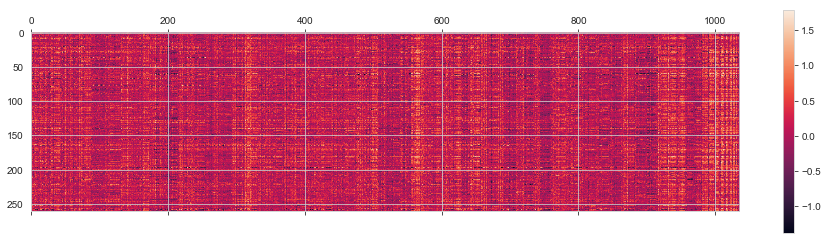

In [4]:
plt.matshow(sfnc_corr_pairs);
plt.colorbar()
plt.show()

###### Feature Selection

In [5]:
demographics = pd.read_excel(os.path.join(data_dir, '20160420_vcalhoun_rest_demography_cag_info_new.xls'))

In [6]:
X = sfnc_corr_pairs
y = demographics.cap_d_group_id2.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1)

### PCA of the training data

### Fitting a simple logistic regression model

### Fitting a linear SVM

### Fitting a RBF SVM

### Fitting a Decision Tree

### Fitting a kNN

### Fitting Random Forests

# FEAST tests

In [8]:
def feast_and_fitting(Xtrain, Xtest, ytrain, ytest):
    
    lr = LogisticRegression(solver='lbfgs')
    svc = LinearSVC(max_iter=100000)
    rbf = SVC(gamma='scale')
    rf = RandomForestClassifier()
    knn  = KNeighborsClassifier()

    algos = [BetaGamma, DISR, CIFE, CMIM, CondMI, Condred]
    num_features_list = range(5, 501, 5)
    classifiers = [lr, svc, rbf, rf, knn]

    acc_matrix = np.zeros((len(algos), len(num_features_list), len(classifiers)))
    f1_matrix = np.zeros(acc_matrix.shape)
    auc_matrix = np.zeros(f1_matrix.shape)

    for i, algo in enumerate(algos):
        for j, num_features in enumerate(num_features_list):
            select_feature_index = algo(Xtrain, ytrain, num_features)

            X_train_select = Xtrain[:, np.array(select_feature_index).astype(int)]
            y_train_select = ytrain

            X_test_select = Xtest[:, np.array(select_feature_index).astype(int)]
            y_test_select = ytest

            for k, classifier in enumerate(classifiers):
                classifier.fit(X_train_select, y_train_select)

                y_pred = classifier.predict(X_test_select)
                false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_select, y_pred)

                acc_matrix[i, j, k] = classifier.score(X_test_select, y_test_select)
                f1_matrix[i, j, k] = f1_score(y_test_select, y_pred)
                auc_matrix[i, j, k] = auc(false_positive_rate, true_positive_rate)

    print_plots(acc_matrix, f1_matrix, auc_matrix)

In [9]:
def print_plots(acc_matrix, f1_matrix, auc_matrix):
    classifier_labels = ['lr', 'svc', 'rbf', 'rf', 'knn']
    algo_labels = ['BetaGamma', 'DISR', 'CIFE', 'CMIM', 'CondMI', 'Condred']
    for i in range(acc_matrix.shape[0]):
        plt.figure(i)
        for j in range(acc_matrix.shape[2]):
            plt.plot(acc_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
            plt.title('Accuracy - ' + algo_labels[i])
            plt.legend()

        plt.show()

    for i in range(acc_matrix.shape[0]):
        plt.figure(i)
        for j in range(acc_matrix.shape[2]):
            plt.plot(f1_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
            plt.title('F1 - ' + algo_labels[i])
            plt.legend()

        plt.show()

    for i in range(acc_matrix.shape[0]):
        plt.figure(i)
        for j in range(acc_matrix.shape[2]):
            plt.plot(auc_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
            plt.title('AUC - ' + algo_labels[i])
            plt.legend()

        plt.show()

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


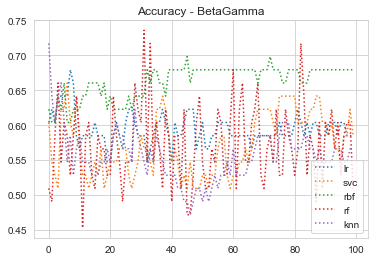

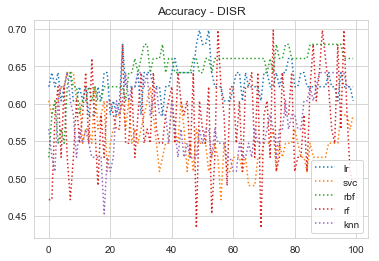

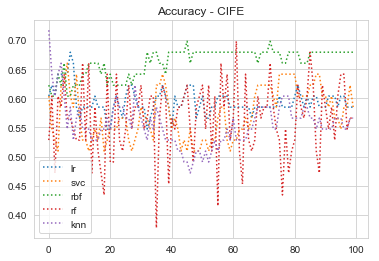

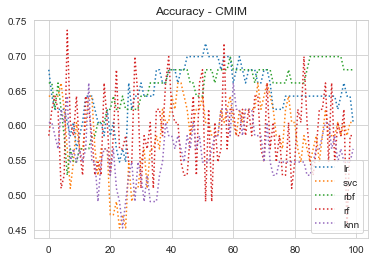

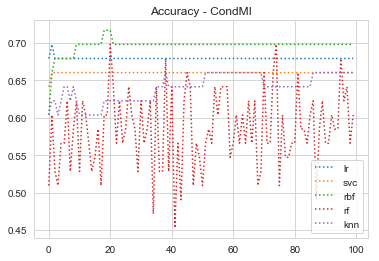

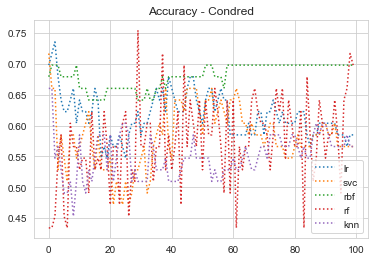

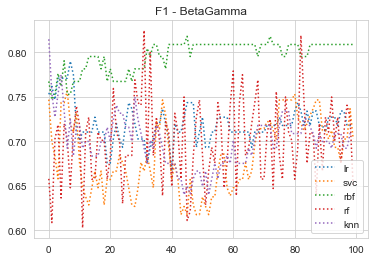

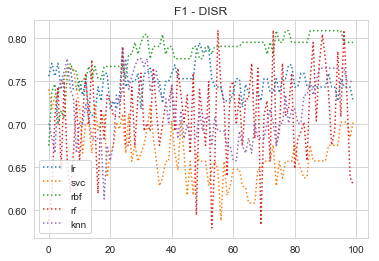

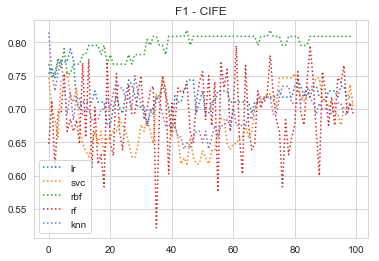

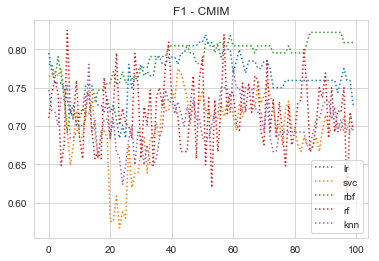

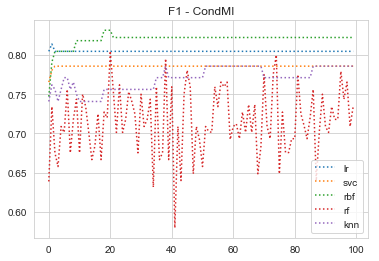

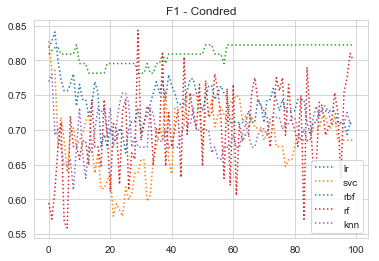

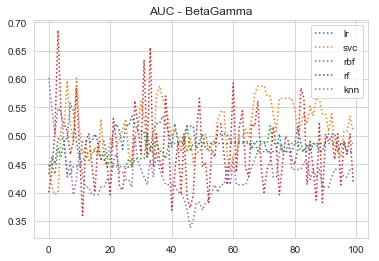

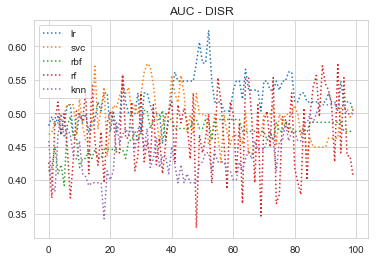

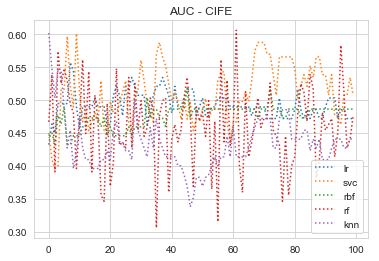

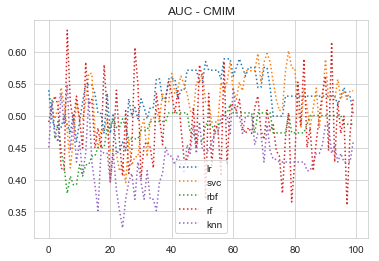

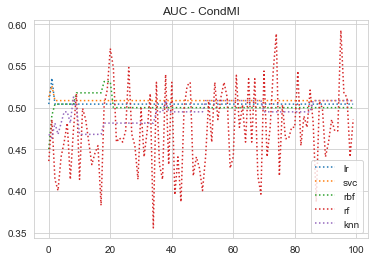

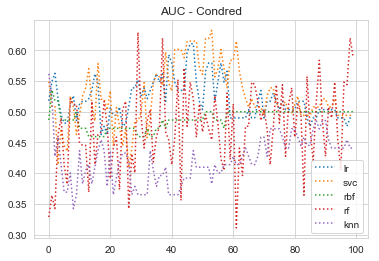

In [10]:
feast_and_fitting(X_train, X_test, y_train, y_test)

### Regressing out the covariates from the sfnc correlation pairs

In [11]:
hd_X = sio.loadmat(os.path.join(data_dir, 'mancovan_april19', 'hd_X.mat'))
hd_X = hd_X['hd_X'][:, :-1]  # excluding the last column as it corresponds to CAG

In [12]:
a = np.linalg.inv(np.dot(hd_X.T, hd_X))
resid_X = np.zeros(sfnc_corr_pairs.shape)

for index, row in enumerate(sfnc_corr_pairs.T):
    y_copy = np.reshape(row, (-1, 1))
    b = np.dot(hd_X.T, y_copy)
    beta = np.dot(a, b)
    y_hat = np.dot(hd_X, beta)
    
    resid_X[:, index] = (y_copy - y_hat).ravel()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(resid_X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1)

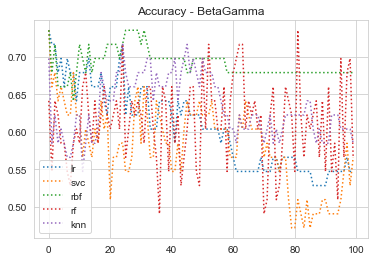

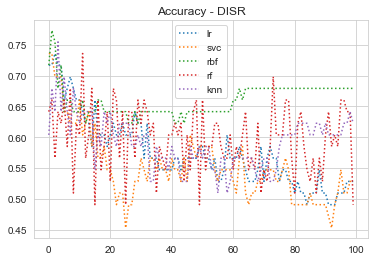

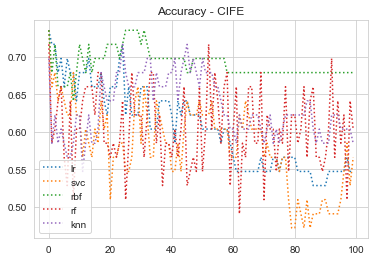

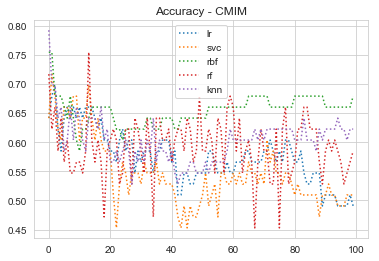

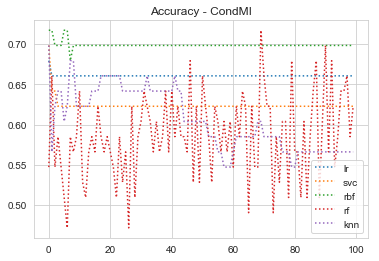

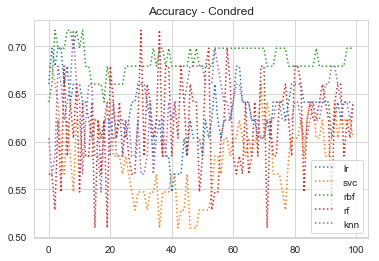

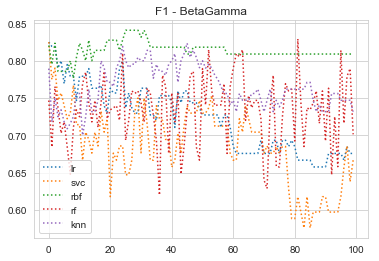

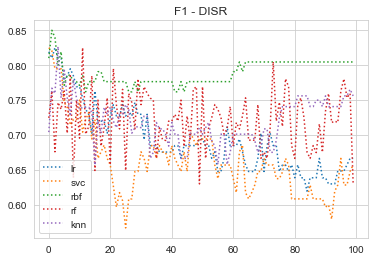

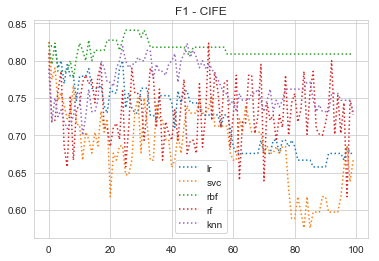

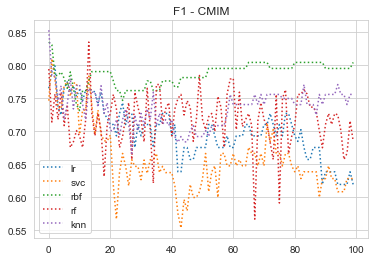

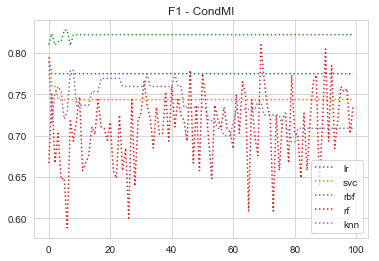

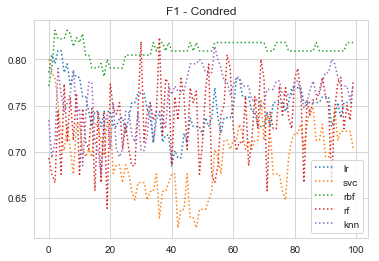

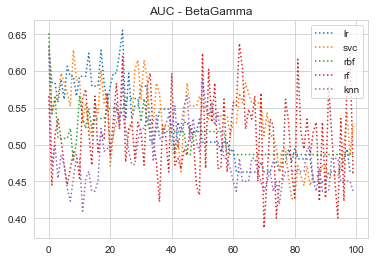

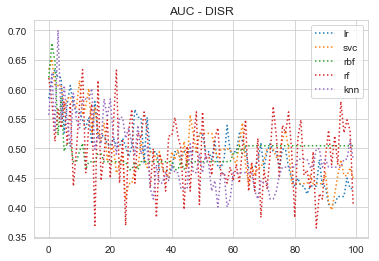

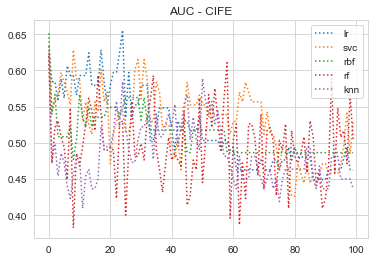

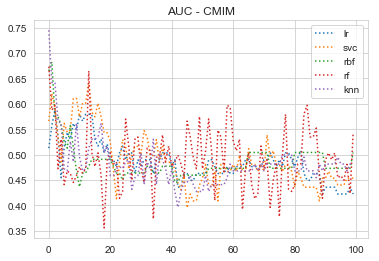

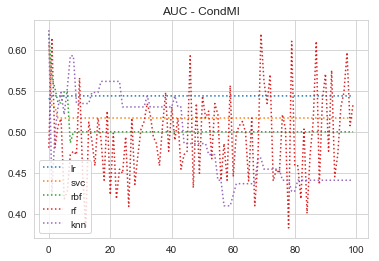

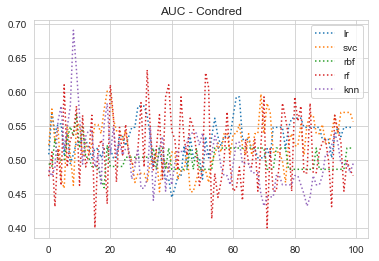

In [14]:
feast_and_fitting(X_train, X_test, y_train, y_test)